# Arbol de Decisión: Clasificación

### Paquetes utilizados

In [75]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from kneed import KneeLocator
from cleaning import CleaningData #propia
from sklearn.cluster import KMeans

#BOpt
from skopt import BayesSearchCV #después lo hacemos con RandomSearchCv

### Carga de datos pre-procesados

In [2]:
# Cargo dataset original y hago un poco de pre processing, luego vamos a tener que cambiarlo para
# incorporar tanto Pre-processing y Feature Engineering. 

raw_df = pd.read_csv("./data/cabaventa.csv")

#borro columnas, borro nulos de un saque, saco "ARS". Me queda un dataset herrrrmoso. 
cleaned = CleaningData(data=raw_df)
cols_to_drop = ['Unnamed: 0.1', 'Unnamed: 0', #columnas que vinieron mal en la bajada
                'operation_type', #todos son 'venta'
                'l1', # todos son 'Argentina'
                'l2', # todos son "Capital Federal"
                'ad_type', #todas las filas iguales 
                'l4', #todas las filas nulas preferible el dato de lat y long
                'l5', #columna con todas las filas nulas
                'l6', #columna con todas las filas nulas
                'created_on', #la columna created_on es igual a la columna start_date
               ]
data = cleaned.drop_columns(columns=cols_to_drop)
data = data.dropna()
data = data[data.currency!="ARS"].reset_index(drop=True)
data.shape

Cleaning columns with no valuable information...



(41315, 17)

## Categorización de la variable precio

El proceso de *binning* de la variable precio se realizó de manera no supervisada, utilizando el algoritmo de k-medias para encontrar las particiones más eficientes, entendiendo la eficiencia como la creación de grupos en los cuales la suma cuadrática de las distancias de cada valor al *centroide* del grupo sea mínima. 

Ejemplo: con una variable que toma valores: 1, 2, 3, 20, 21, 22, 25, 26, 30, 32, 50, 51, 52, 53, 100, 101 si se usaran métodos convencionales como la división en cuartiles quedarían los grupos conformados de la siguiente manera: 

+ 1° grupo: 1,2,3,20 
+ 2° grupo 21, 22, 25, 26  
+ 3° grupo 30, 32, 50, 51
+ 4° grupo 52, 53, 100, 101

Lo que generaría grupos balanceados, pero también compuesto por muestras muy heterogéneas.
En cambio con k-medias, la separación óptima serían 5 grupos: 

+ 1° grupo: 1,2,3
+ 2° grupo 20, 21, 22, 25, 26  
+ 3° grupo 30, 32 
+ 4° grupo 50, 51, 52, 53 
+ 5° grupo 100, 101

En este caso, los grupos quedarían más distinguidos, internamente más homogéneos, aunque se generan muestras desbalanceadas. 
**Nota**: este método de *binning* no constituye una práctica de *hardcoding* de la variable respuesta dado que se ha realizado de manera univariada, sin agregar otros atributos del dataset. 

### Transformación Logarítmica

Previo a la categorización de la variable precio, se realizó una tranformación logarítimica de la variable para quitar el sesgo y hacer más eficiente la separación en intervalos.

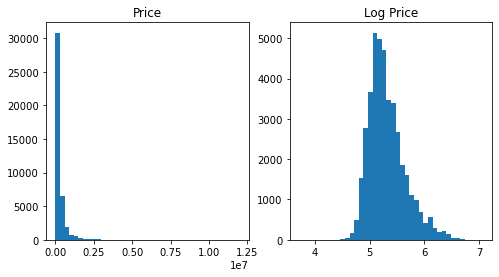

In [3]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(figsize=(8,4), ncols = 2)

axs[0].hist(data.price, bins=40)
axs[0].set_title("Price")

axs[1].hist(np.log10(data.price+1), bins=40)
axs[1].set_title("Log Price")
plt.show()

### K-Medias

El método consiste en definir un hyper-parámetro k, el cual es un 'int', y el algortimo va armando los k-grupos que minimizan la suma de las distancias cuadráticas de cada instancia al centroide (vector de medias del grupo). Dado que aquí se está aplicando el método para un vector de 1 dimensión, es decir se utiliza de modo univariado, el algoritmo lo que hará es separar la variable log-price en k-grupos de modo que se minimice la suma de las distancias cuadráticas de cada valor a la media de su grupo. El punto consiste en encontrar el parámetro k óptimo de modo tal de que se encuentre de manera no supervisada los grupos en los que "naturalmente" está dividida la variable. Para encontrar el parámetro óptimo una de las formas habituales es la solución gráfica del "codo". En un gráfico de dos dimensiones, en el eje horizontal el valor de k y en el eje vertical la suma de las distancias cuadráticas, el valor de k óptimo es allí donde la curva presenta un "codo". 

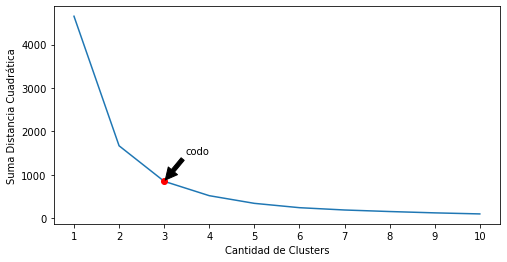

In [4]:
var_data = np.log10(data.price+1).to_numpy().reshape(-1, 1)

kmeans_kwargs = {
  "init": "random",
  "n_init": 10,
  "max_iter": 300,
  "random_state": 42,
  }

max_clusters = 10

sse = []
for k in range(1, max_clusters+1):
  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  kmeans.fit(var_data)
  sse.append(kmeans.inertia_)

kl = KneeLocator(
      range(1, max_clusters+1), sse, curve="convex", direction="decreasing"
                  )
nclust = kl.elbow

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(range(1, max_clusters+1), sse)
ax.plot(nclust,sse[nclust-1], 'ro')
ax.annotate('codo', xy=(3, sse[nclust-1]),  xycoords='data',
            xytext=(4, sse[nclust-2]), textcoords='data',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='top',
            )
ax.set_xticks(range(1, max_clusters+1))
ax.set_xlabel("Cantidad de Clusters")
ax.set_ylabel("Suma Distancia Cuadrática")
plt.show()

Dado que el algortimo selecciona como óptima una separación en 3 grupos, entonces se procede a categorizar la variable log-price en tres grupos, los cuales presentan las siguientes características. 

In [5]:
kl = KneeLocator(
      range(1, max_clusters+1), sse, curve="convex", direction="decreasing"
                  )
nclust = kl.elbow

kmeans = KMeans(
     init="random",
     n_clusters=nclust,
     n_init=10,
     max_iter=300,
     random_state=42)
kmeans.fit(var_data)
data['labels'] = kmeans.labels_

data.groupby('labels').agg({'price':['min','max',lambda x: "{:.2%}".format(x.count()/len(data))]})

price                       
             min         max <lambda_0>
labels                                 
0         5000.0    171700.0     47.65%
1       171800.0    485000.0     39.04%
2       485979.0  12000000.0     13.31%

Tal como se observa, la categorización deriva en la generación de clases desbalanceadas. Este método solo genera clases balanceadas en caso de que la variable se distribuya de manera uniforme. 

In [6]:
norm = np.random.normal(0, 1, 1000).reshape(-1, 1)
unif = np.random.uniform(-1,1,1000).reshape(-1, 1)

km1 = KMeans(
     init="random",
     n_clusters=4,
     n_init=10,
     max_iter=300,
     random_state=42)

km2 = KMeans(
     init="random",
     n_clusters=4,
     n_init=10,
     max_iter=300,
     random_state=42)

print("*"*75)
print("Distribución Normal")
print(pd.Series(km1.fit_predict(norm)).value_counts(normalize=True))
print("*"*75)
print("Distribución Uniforme")
print(pd.Series(km2.fit_predict(unif)).value_counts(normalize=True))

***************************************************************************
Distribución Normal
0    0.351
2    0.343
1    0.177
3    0.129
dtype: float64
***************************************************************************
Distribución Uniforme
1    0.274
2    0.260
0    0.235
3    0.231
dtype: float64


## Modelo

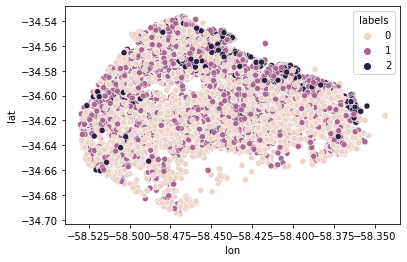

In [7]:
import seaborn as sns
sns.scatterplot(x= "lon", y= "lat", hue="labels", data=data)
plt.show()

### 5-fold Cross Validation

In [56]:
num_vars = ['lat', 'lon', 'rooms', 
            'bedrooms','bathrooms', 'surface_total', 
            'surface_covered']#estas son las que usamos por ahora.
cat_vars = ['l3', 'property_type']
labels = ['labels']

enc = OneHotEncoder(handle_unknown='error', drop="first") 
x_cat = enc.fit_transform(data[cat_vars])

cols = enc.get_feature_names(cat_vars)
cat_df = pd.DataFrame(x_cat.toarray(), columns = cols)
num_df = data[num_vars]
scaler = StandardScaler()
scaled = scaler.fit_transform(num_df)
num_df = pd.DataFrame(scaled, columns = num_vars)
#enc_labs  = OneHotEncoder(handle_unknown='error', drop="first") 
labels = pd.get_dummies(data.labels).to_numpy()

X = pd.concat([data.id, num_df, cat_df], axis=1)

X.shape

(41315, 72)

In [57]:
seed = 13
X_train, x_test, Y_train, y_test = train_test_split(X.iloc[:,1:-1],labels, test_size=0.3, random_state=seed)

In [80]:
import warnings
warnings.filterwarnings('ignore')

model = DecisionTreeClassifier(random_state=seed)

param_grid = {
    'criterion': ['gini', 'entropy'],  #2
    'min_samples_leaf': np.linspace(0.0001,0.1,100), #100
    'max_depth': list(range(4,30))#26
}



opt = BayesSearchCV(
    model,
    search_spaces = param_grid,
    cv=5,
    scoring='roc_auc',
    verbose=3,
    n_iter=100,
    error_score="raise",
    return_train_score=True
    )

opt.fit(X_train, Y_train)

print('Best params achieve a test score of', opt.score(x_test, y_test), ':')

params = dict(opt.best_params_)

from datetime import datetime
hoy = datetime.now().strftime("%Y%m%d%H%M")
 
cv_results = pd.DataFrame(opt.cv_results_)
cv_results.to_csv(f"./resultados/cv_results-{hoy}.csv", index=False)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END criterion=entropy, max_depth=6, min_samples_leaf=0.04248181818181819;, score=(train=0.924, test=0.923) total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=6, min_samples_leaf=0.04248181818181819;, score=(train=0.927, test=0.922) total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=6, min_samples_leaf=0.04248181818181819;, score=(train=0.923, test=0.924) total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=6, min_samples_leaf=0.04248181818181819;, score=(train=0.924, test=0.920) total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=6, min_samples_leaf=0.04248181818181819;, score=(train=0.923, test=0.922) total time=   0.0s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END criterion=gini, max_depth=11, min_samples_leaf=0.08587272727272728;, score=(train=0.901, test=0.897) total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=11, min_samples_leaf=0.085872727272

### Mejor Modelo en Test

In [102]:
cv_results2 = cv_results[[
       'params',
       'mean_test_score','std_test_score', 'rank_test_score', 
       'mean_train_score', 'std_train_score','rank_train_score']].sort_values('mean_test_score')

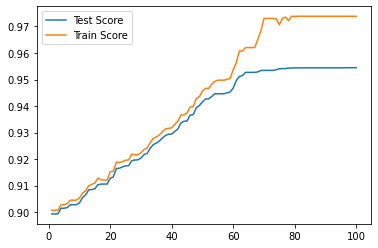

In [105]:
plt.plot(range(1,len(cv_results2.mean_test_score)+1), cv_results2.mean_test_score, label="Test Score")
plt.plot(range(1,len(cv_results2.mean_train_score)+1), cv_results2.mean_train_score, label= "Train Score")
plt.legend()
plt.show()

In [121]:
params = dict(opt.best_params_)

clf = DecisionTreeClassifier(random_state=seed, **params)
#clf = DecisionTreeClassifier(random_state=seed)
clf.fit(X_train, Y_train)
preds = clf.predict(x_test)

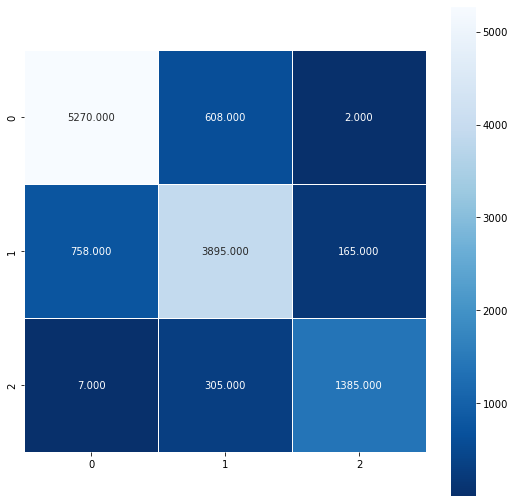

In [122]:
cm = confusion_matrix(y_test.argmax(axis=1), preds.argmax(axis=1))
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.show()

In [125]:
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_test.argmax(axis=1), preds.argmax(axis=1), target_names = target_names))

              precision    recall  f1-score   support

     class 0       0.87      0.90      0.88      5880
     class 1       0.81      0.81      0.81      4818
     class 2       0.89      0.82      0.85      1697

    accuracy                           0.85     12395
   macro avg       0.86      0.84      0.85     12395
weighted avg       0.85      0.85      0.85     12395

